In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pycabnn as cbn

from scipy.spatial import KDTree
from scipy.spatial.distance import pdist

import faiss

import dask.dataframe as dd
from tqdm.dask import TqdmCallback
from dask.diagnostics import ProgressBar

from tqdm.autonotebook import tqdm, trange
from scipy.optimize import curve_fit
from pycabnn.util import HocParameterParser

import util_MLI_conn as umli


In [4]:

h = HocParameterParser()
config_hoc = str("../test_data/params/Parameters.hoc")
h.load_file(config_hoc)

mlipop = cbn.create_population("MLI", h)
mlipop.load_somata("../../big_test_data/MLIcoordinates.dat")
mlipop.add_dendrites()

Successfully read ../../big_test_data/MLIcoordinates.dat.


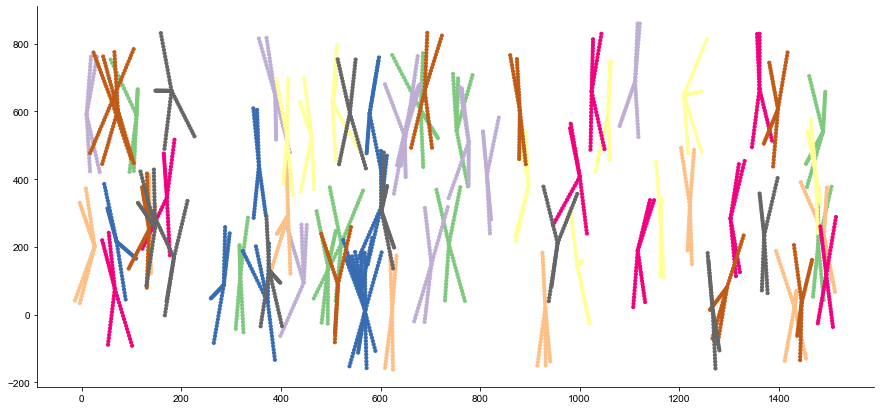

In [5]:
ncell = 70
nidx = ncell*90*4

_, ax = plt.subplots(figsize=(15,7))
ax.scatter(
    mlipop.dends.coo[:nidx:5,0],
    mlipop.dends.coo[:nidx:5,1], 
    10, 
    mlipop.dends.idx[:nidx:5], 
    cmap='Accent'
)

In [6]:
som = mlipop.som
dend_coo = np.reshape(mlipop.dends.coo, (-1, 4, 90, 3))

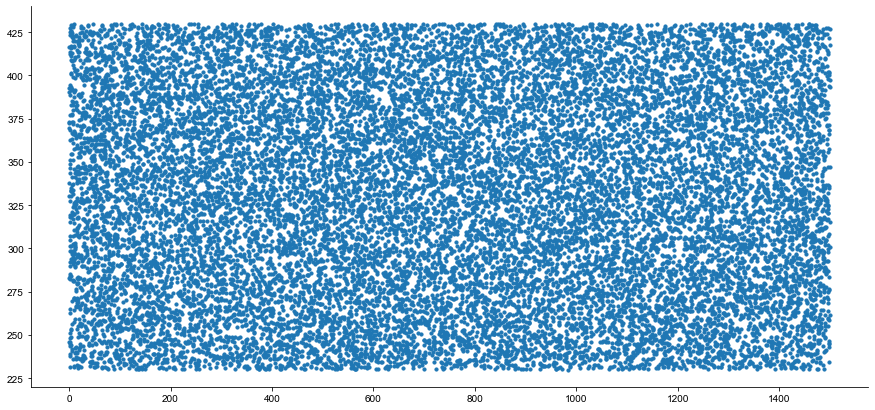

In [101]:
_, ax = plt.subplots(figsize=(15,7))
ax.scatter(som[:,0], som[:,2], 10)


In [109]:
som_dist = umli.compute_soma_dist(mlipop.som)

som_dist = som_dist[som_dist['dist_xy'] < 180]
som_dist = som_dist[som_dist['dist_z'] < 50]

  0%|          | 0/19723 [00:00<?, ?it/s]

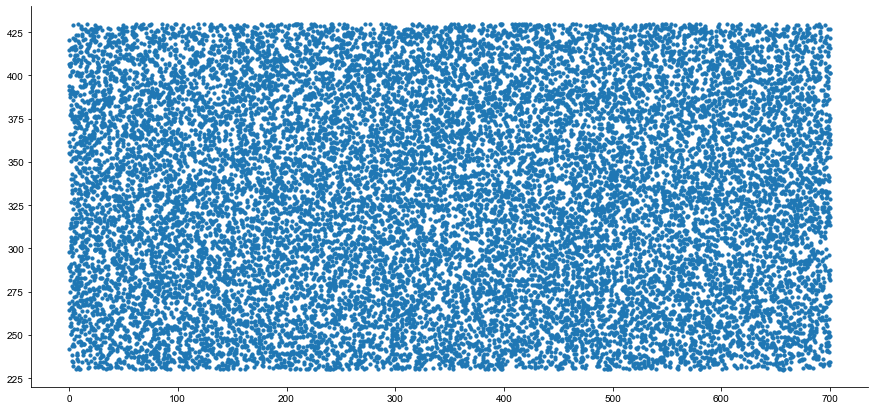

In [106]:
z = som[:, [1, 2]]
_, ax = plt.subplots(figsize=(15,7))
ax.scatter(z[:,0], z[:,1], 10)
dxy = pdist(z)


In [107]:
max(dxy)

723.7986319570057

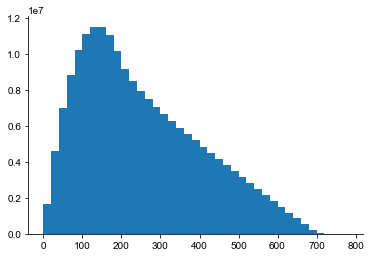

In [103]:
dxy = pdist(som[:, [1, 2]])
_ = plt.hist(dxy, bins=np.arange(0, 800, 20))

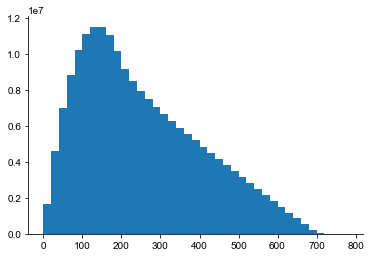

In [100]:
_ = plt.hist(som_dist['dist_xy'], bins=np.arange(0, 800, 20))

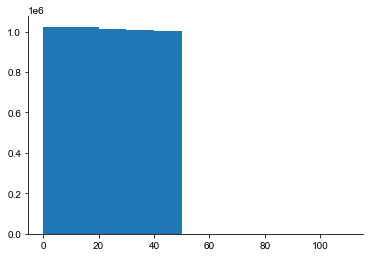

In [9]:
_ = plt.hist(som_dist['dist_z'], bins=np.arange(0, 120, 10))

In [10]:
dend_coo = np.reshape(mlipop.dends.coo, (som.shape[0], -1, 3))

def compute_dend_dist(input_pairs):
    def _min_dend_dist(i, j):
        dend1 = dend_coo[int(i),:,:]
        dend2 = dend_coo[int(j),:,:]
        tree1 = KDTree(dend1)
        z, _ = tree1.query(dend2, k=1)
        return z.min()
    
    zs = []
    for i in range(input_pairs.shape[0]):
        r = input_pairs.iloc[i]
        zs.append(_min_dend_dist(r.i, r.j))
    return zs


## Distance vs connectivity data

(0.0, 200.0)

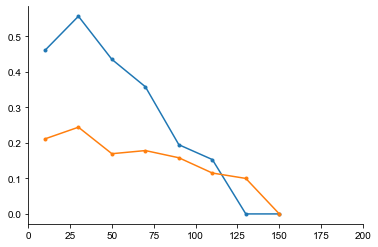

In [11]:
p_dist_xy = np.loadtxt('p_dist_xy.csv', delimiter=',')
plt.plot(p_dist_xy[:,0], (p_dist_xy[:,1:]),'.-')
plt.xlim([0, 200])

(0.0, 200.0)

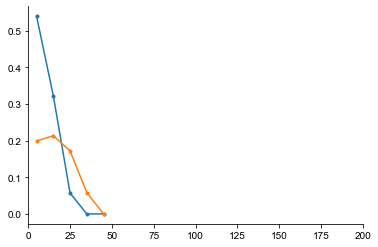

In [12]:
p_dist_z = np.loadtxt('p_dist_z.csv', delimiter=',')
plt.plot(p_dist_z[:,0], p_dist_z[:,1:],'.-')
plt.xlim([0, 200])

## Gap junction

In [13]:
import util_MLI_conn as umli

In [14]:
p_dist_z[:,0]

array([ 5., 15., 25., 35., 45.])

/Users/shhong/Documents/Josefine/pycabnn/notebooks/util_MLI_conn.py:52: RuntimeWarning: invalid value encountered in true_divide
  return pdata_gap_xy(x) / pprior_xy(x)


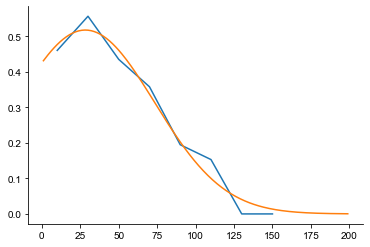

In [15]:
plt.plot(
    p_dist_xy[:, 0],
    p_dist_xy[:, 1],
    np.arange(200),
    umli.p_gap_xy(np.arange(200))
)



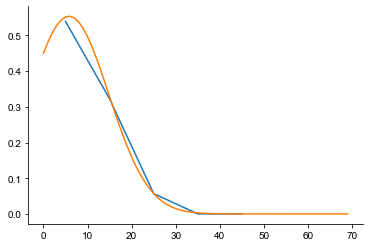

In [16]:
plt.plot(p_dist_z[:,0], p_dist_z[:,1], np.arange(70), umli.p_gap_z(np.arange(70)))

## Synaptic connection

/Users/shhong/Documents/Josefine/pycabnn/notebooks/util_MLI_conn.py:61: RuntimeWarning: invalid value encountered in true_divide
  


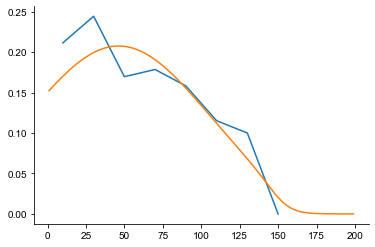

In [39]:
plt.plot(
    p_dist_xy[:, 0],
    p_dist_xy[:, 2],
    np.arange(200),
    umli.p_syn_xy(np.arange(200))
)

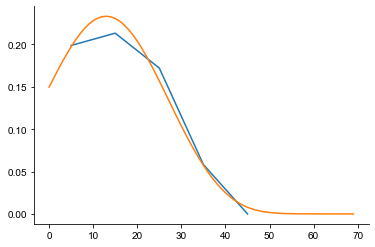

In [45]:
plt.plot(p_dist_z[:, 0], p_dist_z[:, 2], np.arange(70), umli.p_syn_z(np.arange(70)))


## Gap junction on dendrites

In [61]:
selected = som_dist.query('dist_xy < 50 & dist_z <10')

In [225]:
selected.sort_values('dist_xy')

,i,j,dist_xy,dist_z
186151407,15635,16733,0.713817,8.980201
105207555,6359,10619,0.737933,8.304446
30640354,1620,2105,0.895419,7.935873
86648288,5036,6427,1.374044,8.301078
37174046,1984,12735,1.491705,9.110249
...,...,...,...,...
94154152,5556,10511,49.998358,5.332170
165908457,12160,15658,49.998712,5.419957
160206645,11440,18046,49.998986,4.525516
19267236,1002,7294,49.999083,5.820778


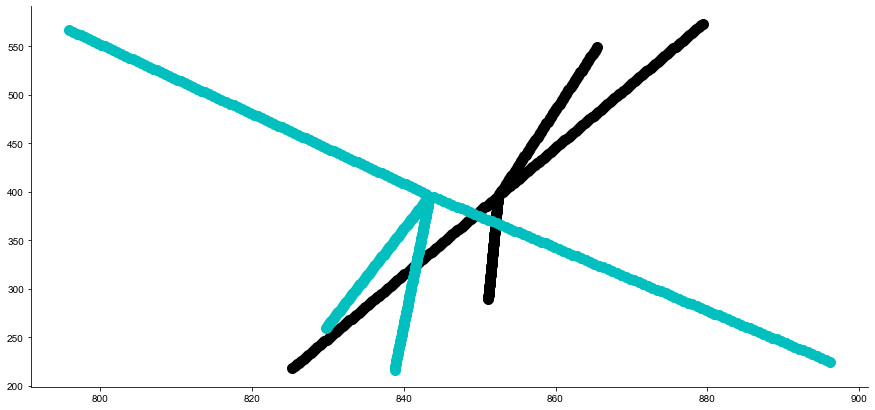

In [232]:
dendcoo = mlipop.dends.coo.reshape(-1, 4, 90, 3)
dendcoo = mlipop.dends.coo.reshape(-1, 4*90, 3)
# dendcoo = dendcoo[:,:,::10,:].reshape(dendcoo.shape[0], -1, 3)

i1 = 15635
i2 = 16733

x1 = dendcoo[i1]
x2 = dendcoo[i2]
x3 = dendcoo[i2-1]
x4 = dendcoo[i2+1]

_, ax = plt.subplots(figsize=(15,7))
ax.scatter(x1[:,0], x1[:,1], 100, 'k')
ax.scatter(x2[:,0], x2[:,1], 100, 'c')
# ax.scatter(x3[:,0], x3[:,1], 20, 'g')
# ax.scatter(x4[:,0], x4[:,1], 20, 'c')

In [230]:
ndend = 4
dendcoo = mlipop.dends.coo
dendcoo = dendcoo.reshape(mlipop.som.shape[0], ndend, -1, 3)

x1 = dendcoo[i1]
x2 = dendcoo[i2]

z = []

for i in range(ndend):
    x1d = x1[i]
    x1d = x1d.astype(np.float32)

    index = faiss.IndexFlatL2(x1d.shape[-1])  # build the index
    index.add(x1d)

    for j in range(ndend):

        # minimal distance between x1d and x2d
        x2d = x2[j]
        x2d = x2d.astype(np.float32)
        D, I = index.search(x2d, 1)
        D, I = D[:, 0], I[:, 0]
        ic2 = D.argmin()
        z.append(
            {
                "dend1": i,
                "dend2": j,
                "i1": I[ic2],
                "i2": ic2,
                "distance": np.sqrt(D[ic2]),
            }
        )

z = pd.DataFrame(z).sort_values(by=['distance'], ignore_index=True)
print(z.loc[:8])


   dend1  dend2  i1  i2  distance
0      1      2   8   9  2.669270
1      1      1  16  16  6.354133
2      2      2   0   1  8.215838
3      1      3   0   0  9.041571
4      2      1   0   0  9.110434
5      2      3   0   0  9.124144
6      3      2   0   0  9.130991
7      0      2   0   0  9.347460
8      3      3   0   0  9.708244


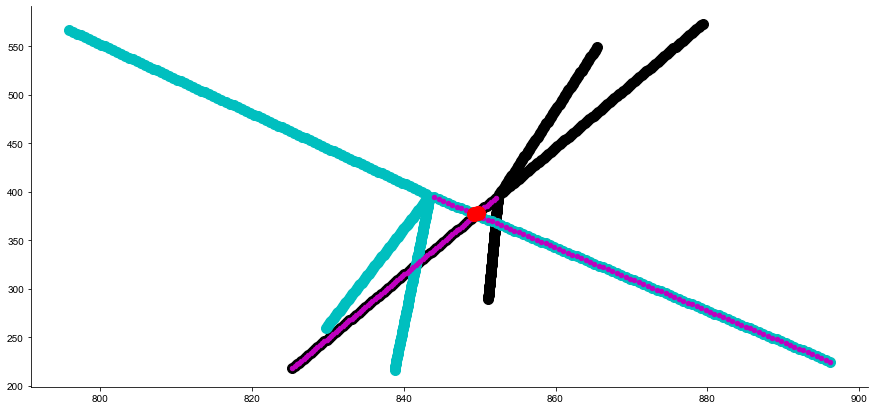

In [231]:
dendcoo = mlipop.dends.coo.reshape(-1, 4*90, 3)
# dendcoo = dendcoo[:,:,::10,:].reshape(dendcoo.shape[0], -1, 3)


x1 = dendcoo[i1]
x2 = dendcoo[i2]
x3 = dendcoo[i2-1]
x4 = dendcoo[i2+1]

_, ax = plt.subplots(figsize=(15,7))
ax.scatter(x1[:,0], x1[:,1], 100, 'k')
ax.scatter(x2[:,0], x2[:,1], 100, 'c')
# ax.scatter(x3[:,0], x3[:,1], 20, 'g')
# ax.scatter(x4[:,0], x4[:,1], 20, 'c')

dendcoo = mlipop.dends.coo.reshape(-1, 4, 90, 3)
x1 = dendcoo[i1]
x2 = dendcoo[i2]
# d1, d2, ix1, ix2 = 3, 0, 17, 13
# d1, d2, ix1, ix2 = 1, 2, 1, 8
d1, d2, ix1, ix2 = 1, 2, 8, 9
ax.scatter(x1[d1,:,0],  x1[d1,:,1], 20, 'm')
ax.scatter(x2[d2,:,0],  x2[d2,:,1], 20, 'm')
ax.scatter(x1[d1,ix1,0], x1[d1,ix1,1], 200, 'r')
ax.scatter(x2[d2,ix2,0], x2[d2,ix2,1], 200, 'r')

# ax.scatter(x2[:,0], x2[:,1], 100, 'c')

### Compute all possible connections

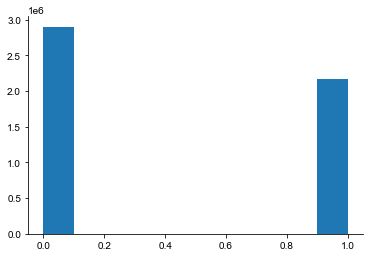

In [171]:
som_dist['p_gap'] = (som_dist['dist_xy']<140).astype('double')*(som_dist['dist_z']<30).astype('double')
_ = plt.hist(som_dist['p_gap'])

In [172]:
pcons = som_dist['p_gap'].values
rx = np.random.uniform(0, 1, pcons.shape)
(pcons>rx).sum()/som_dist.shape[0]


0.4278902687779061

In [147]:
Npair = som_dist.shape[0]

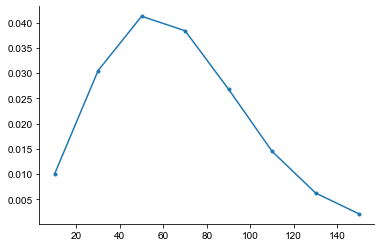

In [142]:
# dz = som_dist[pcons>rx]['dist_xy']
# cc, _ = np.histogram(dz, bins=np.arange(0, 60, 10))
cc, _ = np.histogram(dz, bins=np.arange(0, 180, 20))
plt.plot(p_dist_xy[:,0], cc/Npair, '.-')

In [57]:
p_dist_xy[:,0]

array([ 10.,  30.,  50.,  70.,  90., 110., 130., 150.])

In [58]:
p_dist_z[:,0]

array([ 5., 15., 25., 35., 45.])

In [66]:
p_dist_z[:,2].sum()

0.6424242424242422